# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Python Base Libraries
#from collections import OrderedDict
import json
#import time

# Python Imaging Library module(s)
from PIL import Image

# Libraries for Numpy Operations and Plotting
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib config(s) for better display on notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Pytorch Core Libraries
import torch
import torchvision
from torchvision import datasets, transforms, models

# Pytorch Libraries for Deep Learning 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Pytorch Library for Loss Function and Optimization
import torch.optim as optim

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'

In [3]:
# Transforms for all data sets
t_to_tensor = transforms.ToTensor()
t_normalize = transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]
                        )

# Training set transforms
t_random_rotation = transforms.RandomRotation(75) 
t_random_resize_crop = transforms.RandomResizedCrop(224) 
t_random_h_flip  = transforms.RandomHorizontalFlip()

# Validation and Testing set transforms
t_resize = transforms.Resize(256)
t_center_crop = transforms.CenterCrop(224)


# Defining transforms for the training, validation, and testing sets
data_transforms = {
        'train': transforms.Compose([
            t_random_rotation, 
            t_random_resize_crop,
            t_random_h_flip,
            t_to_tensor, 
            t_normalize
        ]),
        'valid': transforms.Compose([
            t_resize,
            t_center_crop,
            t_to_tensor, 
            t_normalize
        ]),
        'test': transforms.Compose([
            t_resize,
            t_center_crop,
            t_to_tensor, 
            t_normalize
        ]),
}

# Data Loading: Defining datasets
image_datasets = {
            data: datasets.ImageFolder(data_dir+'/'+data, transform=data_transforms[data]) 
            for data in data_transforms
}


# Data Batching: Defining dataloaders for image_datasets
dataloaders = {
        data: torch.utils.data.DataLoader(image_datasets[data], batch_size=64, shuffle=True)
        for data in image_datasets
}


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [5]:
class FFClassifier(nn.Module):
    ''' Defines Feedforward Classifier'''
    def __init__(self, input_size, output_size, hidden_layer_sizes, drop_p=0.5):
        
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.hidden_layers, self.output = self.compute_connected_layers()
        
        ### Dropout probability
        self.dropout_p = drop_p
        
        # Prevent overfitting with Dropout
        self.dropout = nn.Dropout(p=drop_p)   
        
      
    def forward(self, inputs):
        ''' Forward pass through the network '''
        
        # Feed-Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            inputs = F.relu(linear(inputs))
            inputs = self.dropout(inputs)
    
        # Feed-Forward toward output layer
        inputs = self.output(inputs)

        # Apply Log-Softmax
        optimized_output = F.log_softmax(inputs, dim=1)
        
        return optimized_output
    
    
    def compute_connected_layers(self):
        ''' Creates a deep network for the classifier '''
        
        # Create ModuleList and input-to-first-hidden layer connection
        hidden_layers = nn.ModuleList([nn.Linear(self.input_size, self.hidden_layer_sizes[0])])

        # Create inter-hidden-layer connections
        layer_sizes = zip(self.hidden_layer_sizes[:-1], self.hidden_layer_sizes[1:])
        # Add hidden layers to the ModuleList
        hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])   
        
        # Create a last-hidden-to-output layer connection
        output = nn.Linear(self.hidden_layer_sizes[-1], self.output_size)
        
        return hidden_layers, output


In [6]:
class DerivedModel:
    ''' Defines a model that uses a pretrained model with more functionalities'''
    
    def __init__(self):
        
        # Load pretrained model
        self.base_model = self.get_pretrained_model()

        #### Parameters ####
        self.class_to_idx = None # Training Data Class-to-Index Mapping
        self.learn_rate = None # Network's learning rate
        self.device = None # CPU or GPU
        self.epochs = None # Training epochs
        self.optimizer = None # Model optimizer
        self.criterion = None # Error function
        
    
    def get_pretrained_model(self):
        ''' Loads and configures a pre-trained model '''
        
        # Loading a Pre-trained network
        vgg16_model = models.vgg16(pretrained=True)

        # Freezing Parameters for the VGG16 model i.e., no backproping through them
        for param in vgg16_model.parameters():
            param.requires_grad = False
        
        return vgg16_model 
    

    def assign_new_classifier(self, output_size, hidden_layer_sizes, image_dataset, drop_p=0.5):
        ''' Creates new classifier for the pre-trained model '''
        
        # Gets class-to-index mapping from data set 
        self.class_to_idx = image_dataset.class_to_idx
        
        # Assigns pre-trained network's input size to new classifer input size
        input_size = self.base_model.classifier[0].in_features
        
        # Instantiate FFClassifier
        ffclassifier = FFClassifier(input_size, output_size, hidden_layer_sizes, drop_p)
        
        # Assigns newly created classifier to the pre-trained model
        self.base_model.classifier = ffclassifier
        
        
    def assign_optimizer(self, learn_rate=0.0001, optimizer=None):
        ''' 
            Function called after classifier is created.
            Assigns a model optimizer.
            Default:  Adam
        '''
        
        self.learn_rate = learn_rate
        
        if optimizer == None:
            self.optimizer = optim.Adam(self.base_model.classifier.parameters(), lr=learn_rate) 
        else:
            self.optimizer = optimizer

            
    def deep_learn(self, dataloader, epochs=3, print_every=40, criterion=None):
        ''' Performs deep learning on training data set and track progress with validation data set '''
    
        # Epochs
        self.epochs = epochs 
        
        # Error Function: Default(Non-Linear Log Loss)
        self.criterion = nn.NLLLoss() if criterion == None else criterion
        
        # Determine the device to use
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        device = self.device #for readability
        
        # Pass model to appropriate device
        self.base_model.to(device)

        # Initialize batch instance counter
        steps = 0
        
        for e in range(epochs):
            
            # Initialize loss calculation per epoch
            running_loss = 0

            for ii, (inputs, labels) in enumerate(dataloader['train']):
                
                # Incremement batch count
                steps += 1
 
                # Convert tensors to autograd tensors
                inputs = Variable(inputs)
                labels = Variable(labels)
            
                # Pass tensors to available device
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the gradient buffers
                self.optimizer.zero_grad()

                ### Forward and backward passes ###
                outputs = self.base_model.forward(inputs)  # Feed-forward
                loss = self.criterion(outputs, labels) # Calculate error
                loss.backward()  # Backward pass: Backprop 
                self.optimizer.step() # Update weights

                running_loss += loss.item() # Record loss

                if steps % print_every == 0:
                    
                    # Model will be in inference mode and dropouts will be turned off
                    test_loss, accuracy = self.validate(dataloader['valid'])

                    print("\nEpoch: {}/{}.. ".format(e+1, epochs),
                          "\t\t\tTraining Loss: {:.3f}.. ".format(running_loss/print_every),
                          "\nValidation Loss: {:.3f}.. ".format(test_loss),
                          "\tValidation Accuracy: {:.2f} %".format(accuracy))
                    
                    # Initialize loss calculation per batch
                    running_loss = 0

                    # Make sure training is back on: dropouts turned on
                    self.base_model.train()

                    
    def validate(self, testloader):
        ''' Tracks network's prediction accuracy as it learns:
                
            Parameter(s):
                testloader: image_dataset to be used
        '''
        test_loss = 0
        accuracy = 0
        device = self.device
        
        # Set model to eval mode for inferencing: Turn off dropouts
        self.base_model.eval()

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images, labels in testloader:
                # Convert tensors to autograd tensors
                images = Variable(images)
                labels = Variable(labels)

                images, labels = images.to(device), labels.to(device)

                output = self.base_model.forward(images)
                test_loss += self.criterion(output, labels).item()
                
                # Take the exponential of log-softmax output to get corresponding probabilities
                ps = torch.exp(output)

                # Find class with the highst probability and compare with true label
                equality = (labels.data == ps.max(dim=1)[1])
                
                # Compute Accuracy by taking the mean 
                accuracy += equality.type(torch.FloatTensor).mean()

        # Normalize
        data_size = len(testloader)
        test_loss = test_loss/data_size 
        accuracy = 100*accuracy/data_size # Convert to percentage
        
        return test_loss, accuracy 

In [7]:
''' Build and train the network '''

# Defining parameters
output_size = 102
hidden_layer_sizes = [1024, 512, 256]
epochs = 10
print_every = 60
learn_rate = 0.0001
dropout_p = 0.33

# Instantiate Derived Model
dmodel = DerivedModel()
dmodel.assign_new_classifier(output_size, hidden_layer_sizes, image_datasets['train'], dropout_p)
dmodel.assign_optimizer(learn_rate)

In [8]:
# Do Deep Learning
dmodel.deep_learn(dataloaders, epochs, print_every)


Epoch: 1/10..  			Training Loss: 4.487..  
Validation Loss: 4.130..  	Validation Accuracy: 11.26 %

Epoch: 2/10..  			Training Loss: 1.100..  
Validation Loss: 3.290..  	Validation Accuracy: 28.46 %

Epoch: 2/10..  			Training Loss: 3.485..  
Validation Loss: 2.528..  	Validation Accuracy: 44.11 %

Epoch: 3/10..  			Training Loss: 1.667..  
Validation Loss: 2.027..  	Validation Accuracy: 49.52 %

Epoch: 3/10..  			Training Loss: 2.588..  
Validation Loss: 1.630..  	Validation Accuracy: 58.82 %

Epoch: 4/10..  			Training Loss: 1.974..  
Validation Loss: 1.413..  	Validation Accuracy: 65.67 %

Epoch: 5/10..  			Training Loss: 0.255..  
Validation Loss: 1.210..  	Validation Accuracy: 67.99 %

Epoch: 5/10..  			Training Loss: 1.965..  
Validation Loss: 1.039..  	Validation Accuracy: 74.53 %

Epoch: 6/10..  			Training Loss: 0.727..  
Validation Loss: 0.926..  	Validation Accuracy: 78.34 %

Epoch: 6/10..  			Training Loss: 1.716..  
Validation Loss: 0.842..  	Validation Accuracy: 78.00 %


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
loss, acc = dmodel.validate(dataloaders['test'])

In [10]:
print("Loss = {:.3f} \t Accuracy {:.2f} %".format(loss,acc) )

Loss = 0.617 	 Accuracy 83.68 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
def save_checkpoint(model, chkpt_pth):
    '''Save the checkpoint '''
    
    done = False
    model_checkpoint = {
        
    # Classifier-specific parameters
    'output_size': model.base_model.classifier.output_size,
    'hidden_layers': model.base_model.classifier.hidden_layer_sizes,
    'dropout_p': model.base_model.classifier.dropout_p, 
        
    # Model-specific parameters      
    'epochs': model.epochs,
    'learning_rate': model.learn_rate,
    'optimizer' : model.optimizer.state_dict(),
    'state_dict': model.base_model.state_dict() 
        
    }
    
    torch.save(model_checkpoint, checkpoint_path)
    done = True
    
    return done
    
# Save checkpoint
checkpoint_path = 'model_checkpoint.pth'

if save_checkpoint(dmodel, checkpoint_path):
    print("Checkpoint saved in {}".format(checkpoint_path))


Checkpoint saved in model_checkpoint.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [12]:
def load_checkpoint(checkpoint_path):
    ''' Loads a checkpoint and rebuilds the model '''
    
    checkpoint = torch.load(checkpoint_path)
    
    # Retrieve variables for classifier
    out_size = checkpoint['output_size']
    hidden_layer_sizes = checkpoint['hidden_layers']
    dropout_p = checkpoint['dropout_p']
    
    # Retrieve variables for model
    epochs = checkpoint['epochs']
    learning_rate = checkpoint['learning_rate']

    # Re-build model
    model = DerivedModel()
    model.assign_new_classifier(output_size, hidden_layer_sizes, image_datasets['train'], dropout_p)
    model.assign_optimizer(learn_rate)
    model.base_model.load_state_dict(checkpoint['state_dict'])
    model.optimizer.load_state_dict(checkpoint['optimizer'])
    print("Model from '{}' has been successfully loaded".format(checkpoint_path))
    return model  


In [13]:
checkpoint_file_name = 'model_checkpoint.pth'
model = load_checkpoint(checkpoint_file_name)

Model from 'model_checkpoint.pth' has been successfully loaded


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [14]:
def centered_crop(pil_image, new_height, new_width):
    '''
    Code adapted from: 
        https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
    Accessed: 30.09.2018
    '''
    width, height = pil_image.size  
    
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    centered_cropped_image = pil_image.crop((left, top, right, bottom))  # Image.crop rectangular box
    
    return centered_cropped_image

In [15]:
def process_image(image_file):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Resize Image
    size = 256, 256 
    pil_image = Image.open(str(image_file)) # Load Image

    pil_image.thumbnail(size, Image.ANTIALIAS) #Image.ANTIALIAS to keep aspect ratio 
  
    # Center-crop Image
    pil_image = centered_crop(pil_image, 224, 224)
    
    # Possible color channels
    color_channels = 255
    
    # Convert Image (with channels) to Numpy Array (with values between 0 and 1)
    np_image = np.array(pil_image) / color_channels
    
    # Normalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])  
    np_image_array = (np_image - mean) / std
    
    # Reorder dimensions
    np_image_array = np_image_array.transpose((2, 0, 1))
    
    return np_image_array

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [16]:
def imshow(image, ax=None, title=None, normalize=False):
    
    # Convert image to tensor
    t_to_tensor = transforms.ToTensor()
    image = t_to_tensor(image)

    if ax is None:
        fig = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
        ax = fig.add_subplot(412)
    
    if title is not None:
        ax.axis('off') # Remove axis borders
        ax.set_title(title) # Set the title to the predicted image
        
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        # Undo preprocessing
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
    
        # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
        image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [17]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model. '''
    
    #Pre-process Image 
    np_array = process_image(image_path) # Load & Format PIL Image to Numpy Image Array
    tensor_input = torch.from_numpy(np_array) # Convert image_array to torch tensor input
    
    # Determine the device to use
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Turn off dropouts
    model.base_model.eval()
    
    # Pass model to the appropriate device
    model.base_model.to(device)
    
    with torch.no_grad():
        # Autograd Tensor
        m_input = Variable(tensor_input)

        # Pass input object to device
        m_input = m_input.to(device)
        
        # Add one more dimension
        m_input = m_input.unsqueeze(0) 
        
        # Feed input into model
        m_output = model.base_model.forward(m_input.float())
    
        # Top K probabilities
        outcome = torch.exp(m_output).data.topk(topk)
    
    # For to_numpy conversion
    if device == torch.device('cuda'):
        probs = outcome[0].cpu()
        classes = outcome[1].cpu()
    else:
        probs = outcome[0]
        classes = outcome[1]
    
    # Invert class_to_idx dictionary
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    
    # Retrieve predicted class indices 
    pred_classes = [idx_to_class[label] for label in classes.numpy()[0]]
    
    return probs.numpy()[0], pred_classes
    

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

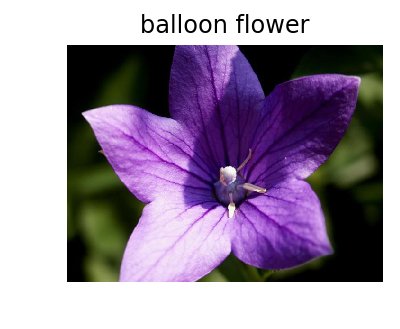

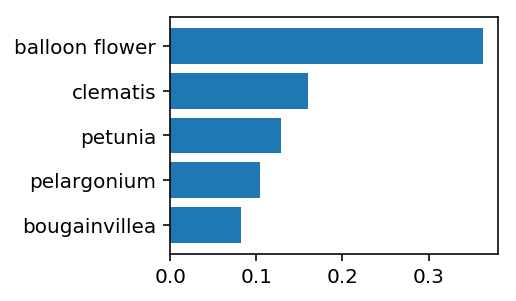

In [18]:
''' Plot input image '''

# Specify image path
image_path = data_dir + '/test/19/image_06175.jpg'

# Filter out image category from image path
image_cat = image_path.split('/')[2]

# Plot image being tested
image = Image.open(image_path)
_title = cat_to_name[image_cat]
imshow(image, title=_title);


''' Plot top 5 predictions ''' 

# Predict the image
probs, classes = predict(image_path, model)

n_groups = len(classes)

fig = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
ax = fig.add_subplot(434)

index = np.arange(n_groups)
#bar_width = 0.8
#opacity = 0.5

# Plot horizontal bar chart
ax.barh(index, probs)

ax.set_yticks(index)
ax.set_yticklabels([cat_to_name[c] for c in classes])

ax.invert_yaxis()

plt.show()